# Problem Set 2

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import statsmodels.tsa.api as tsa
import statsmodels.tsa.stattools as ts
from arch import arch_model
import datetime

## Exercise 1

$$F = \begin{bmatrix}
\text{Top Block} \\
\text{Lower Block}
\end{bmatrix} =
\begin{bmatrix}
A_1 & A_2 \\
\mathbf{I} & \mathbf{0}
\end{bmatrix}$$

In [2]:
def check_stationarity(coefficients):
    p = len(coefficients)
    k = coefficients[0].shape[0]

    top_block = np.hstack(coefficients)

    if p == 1:
        F = top_block
    else:  # We rewrite any VAR(p) as VAR(1)
        lower_block = np.hstack([np.eye(k * (p - 1)), np.zeros((k * (p - 1), k))])
        F = np.vstack([top_block, lower_block])

    eigenvalues = np.linalg.eigvals(F)
    moduli = np.abs(eigenvalues)
    is_stationary = np.all(moduli < 1)

    print(f"Model Order (p): {p}")
    print(f"Companion Matrix Dimension: {F.shape}")
    print("Eigenvalues:")
    for val in eigenvalues:
        print(f"  {val:.4f}")

    print(f"\nMax Modulus: {np.max(moduli):.4f}")
    if is_stationary:
        print("Result: The VAR model is STATIONARY (all moduli < 1).")
    else:
        print("Result: The VAR model is NON-STATIONARY (at least one modulus >= 1).")
    print("\n")

### (a)

In [3]:
A1_a = np.array([[0.5, 0.3], [1.2, 0.2]])
check_stationarity([A1_a])

Model Order (p): 1
Companion Matrix Dimension: (2, 2)
Eigenvalues:
  0.9685
  -0.2685

Max Modulus: 0.9685
Result: The VAR model is STATIONARY (all moduli < 1).




### (b)

In [4]:
A1_b = np.array([[0.6, 0.4], [0.5, 0.2]])
A2_b = np.array([[0.1, 0.3], [0.2, 0.6]])

check_stationarity([A1_b, A2_b])

Model Order (p): 2
Companion Matrix Dimension: (4, 4)
Eigenvalues:
  1.3085
  0.1692
  -0.0000
  -0.6777

Max Modulus: 1.3085
Result: The VAR model is NON-STATIONARY (at least one modulus >= 1).




As we can see, for 1 (a), all absolute Eigenvalues (modulus) are $<1$, meaning the VAR model is stationary. In 1 (b) however, not all modulus are $<1$, so this VAR model is non-stationary.

## Exercise 2

In [5]:
def sns_lineplot(title, x, xlabel, y, ylabel, data):
    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 6))
    sns.lineplot(data=data, x=x, y=y, linewidth=2, color="#2E86AB")

    plt.title(title, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.grid(alpha=0.3, linestyle="--")
    plt.tight_layout()
    plt.show()

In [6]:
data_folder = "../data/exercise2"
df_dict = {
    filename.replace(".csv", "").upper(): pd.read_csv(
        os.path.join(data_folder, filename),
        parse_dates=["observation_date"],
        index_col="observation_date",
    )
    for filename in os.listdir(data_folder)
    if filename.endswith(".csv")
}

### (a)

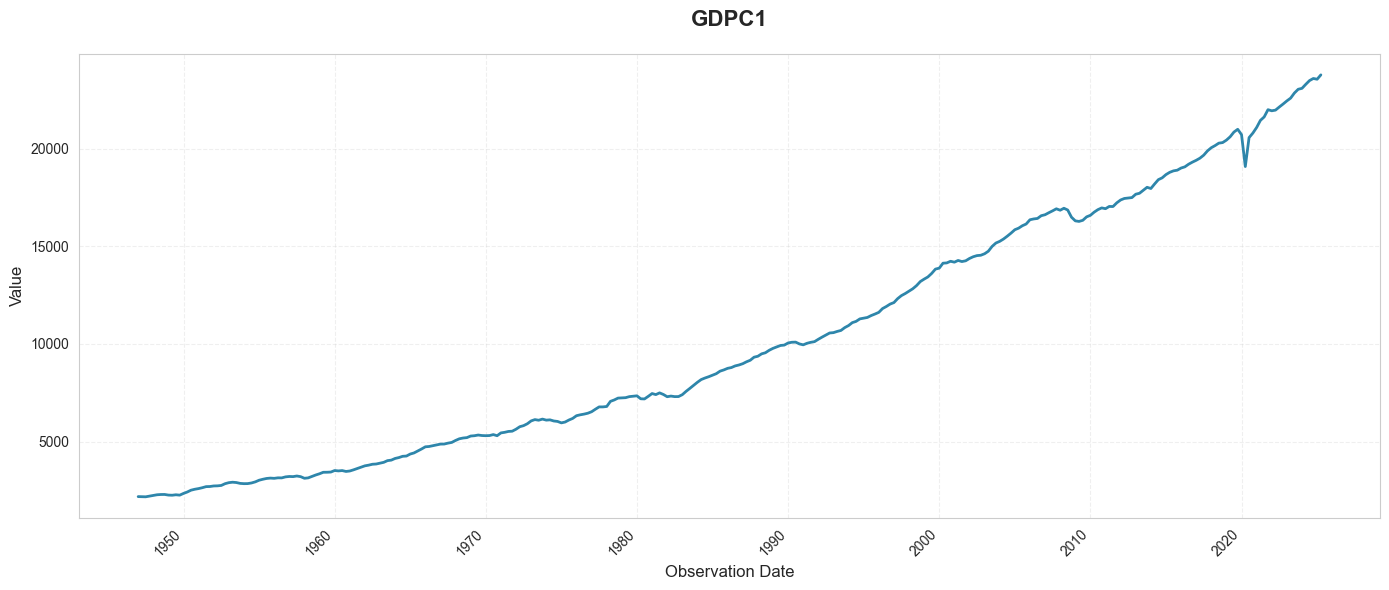

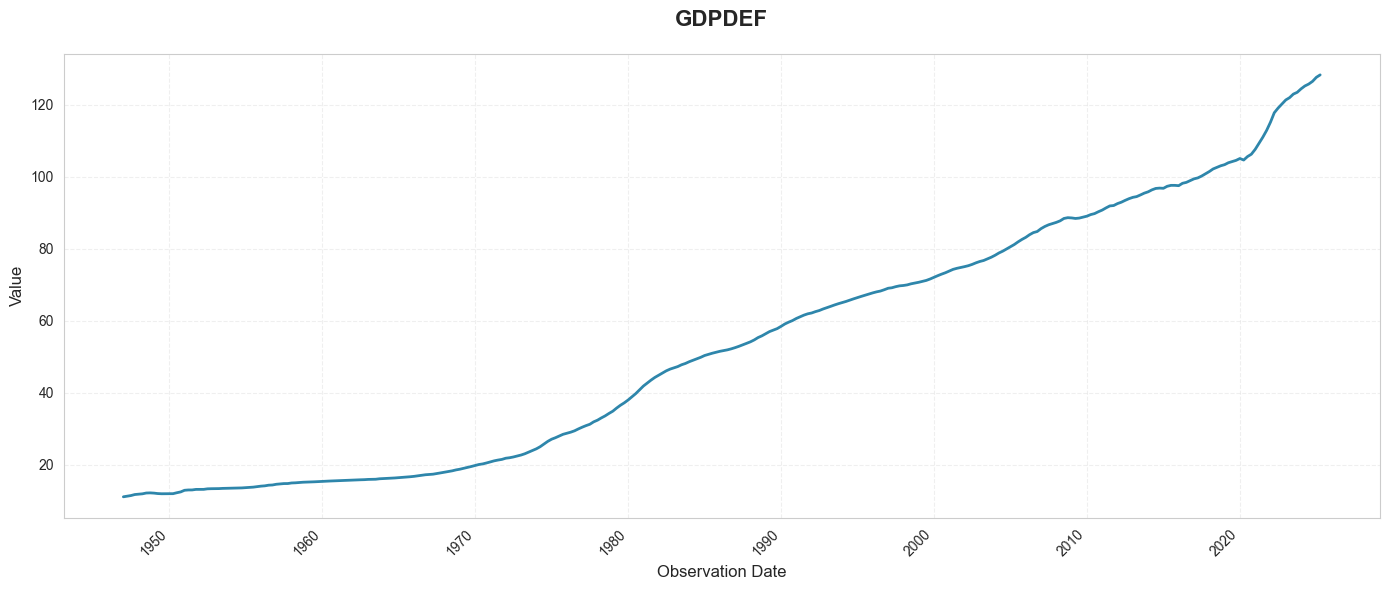

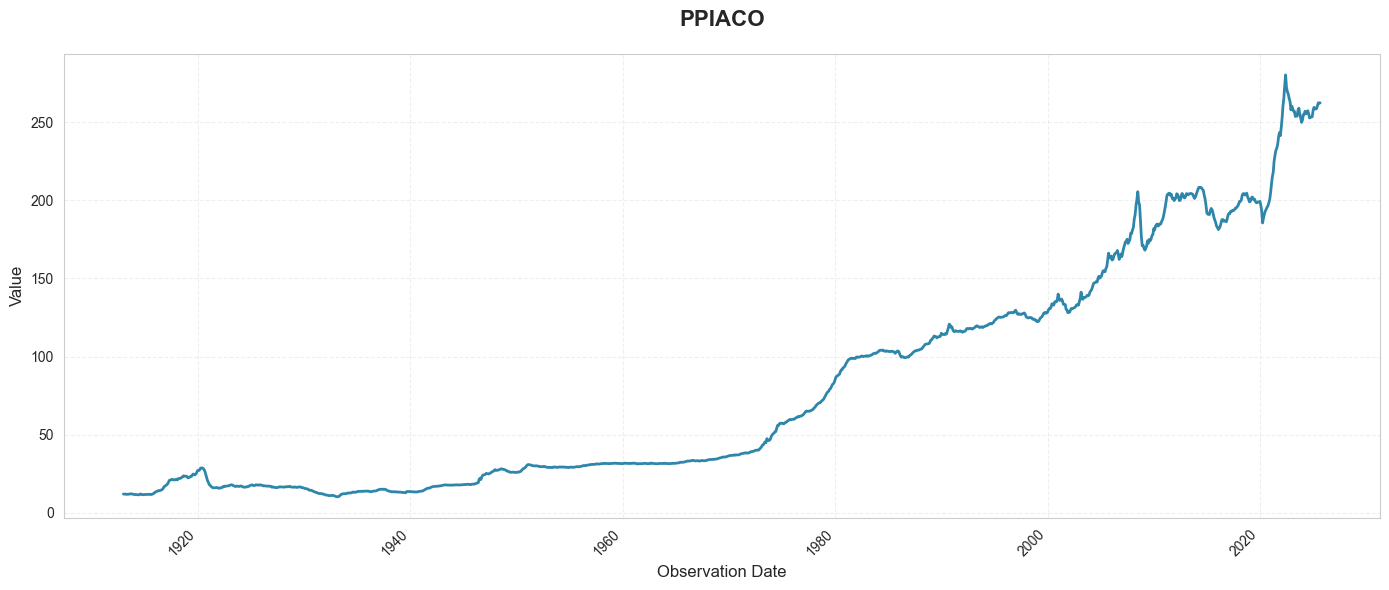

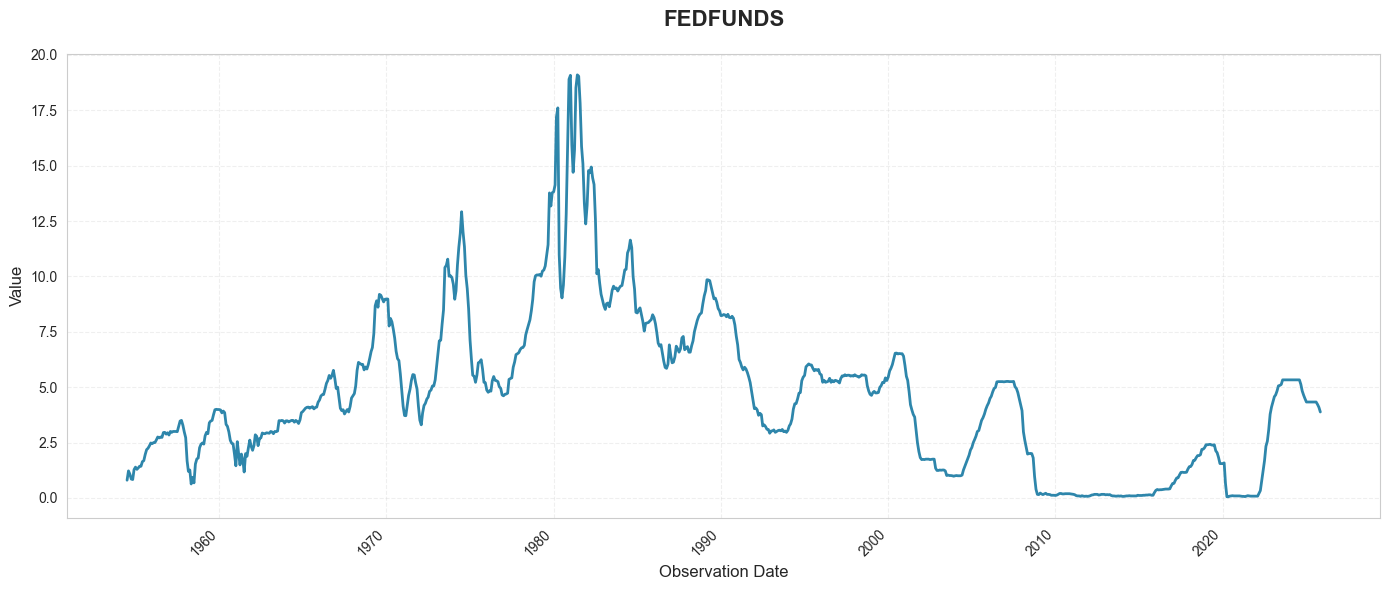

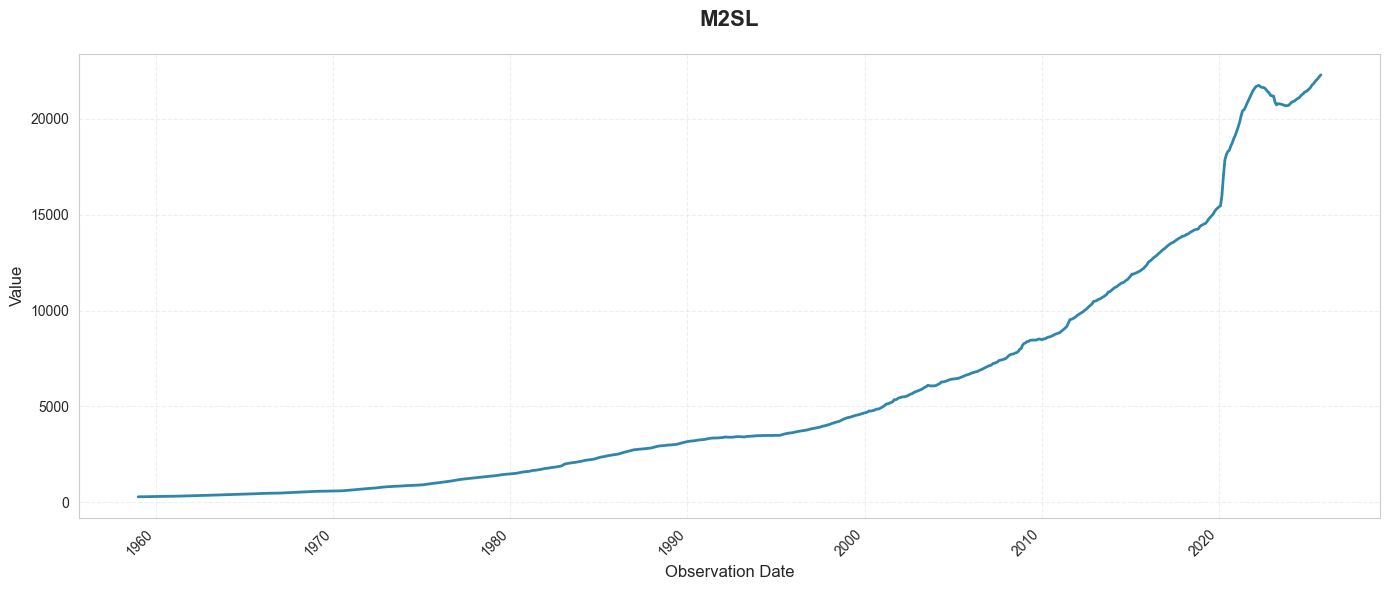

In [7]:
for key, df in df_dict.items():
    sns_lineplot(key, "observation_date", "Observation Date", key, "Value", df)

### (b)

In [8]:
for key, df in df_dict.items():
    if "FEDFUNDS" not in key:
        df[key] = np.log(df[f"{key}"])

In [9]:
for key, df in df_dict.items():
    if key in ["PPIACO", "M2SL", "FEDFUNDS"]:
        df_dict[key] = df.resample("QS").mean()

In [10]:
df_q = pd.concat([df for df in df_dict.values()], axis=1)
df_q = df_q.dropna()
df_q.head()

,GDPC1,GDPDEF,PPIACO,FEDFUNDS,M2SL
observation_date,,,,,
1959-01-01,8.117351,2.722873,3.456317,2.570000,5.662375
1959-04-01,8.139635,2.724448,3.458416,3.083333,5.677195
1959-07-01,8.140332,2.728310,3.455263,3.576667,5.690695
1959-10-01,8.143178,2.732222,3.451044,3.990000,5.694179
1960-01-01,8.165415,2.736184,3.455260,3.933333,5.699215


In [11]:
model = tsa.VAR(df_q)

max_lags = 8
selection = model.select_order(maxlags=max_lags)

print(selection.summary())

print(f"\nAIC recommends p = {selection.aic}")
print(f"BIC recommends p = {selection.bic}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -13.25      -13.18   1.757e-06      -13.22
1      -38.16      -37.75   2.672e-17      -37.99
2      -39.77     -39.01*   5.337e-18      -39.47
3      -39.94      -38.84   4.515e-18     -39.50*
4     -39.94*      -38.50  4.501e-18*      -39.36
5      -39.90      -38.11   4.728e-18      -39.18
6      -39.91      -37.77   4.688e-18      -39.05
7      -39.80      -37.32   5.221e-18      -38.81
8      -39.73      -36.91   5.640e-18      -38.59
-------------------------------------------------

AIC recommends p = 4
BIC recommends p = 2


As we can see from the selection summary, AIC recommends a lag ($p$) of 4, while BIC recommends $p = 2$. We will use $p = 4$ as this is more common for quarterly data.

### (c)

<Figure size 1000x1200 with 0 Axes>

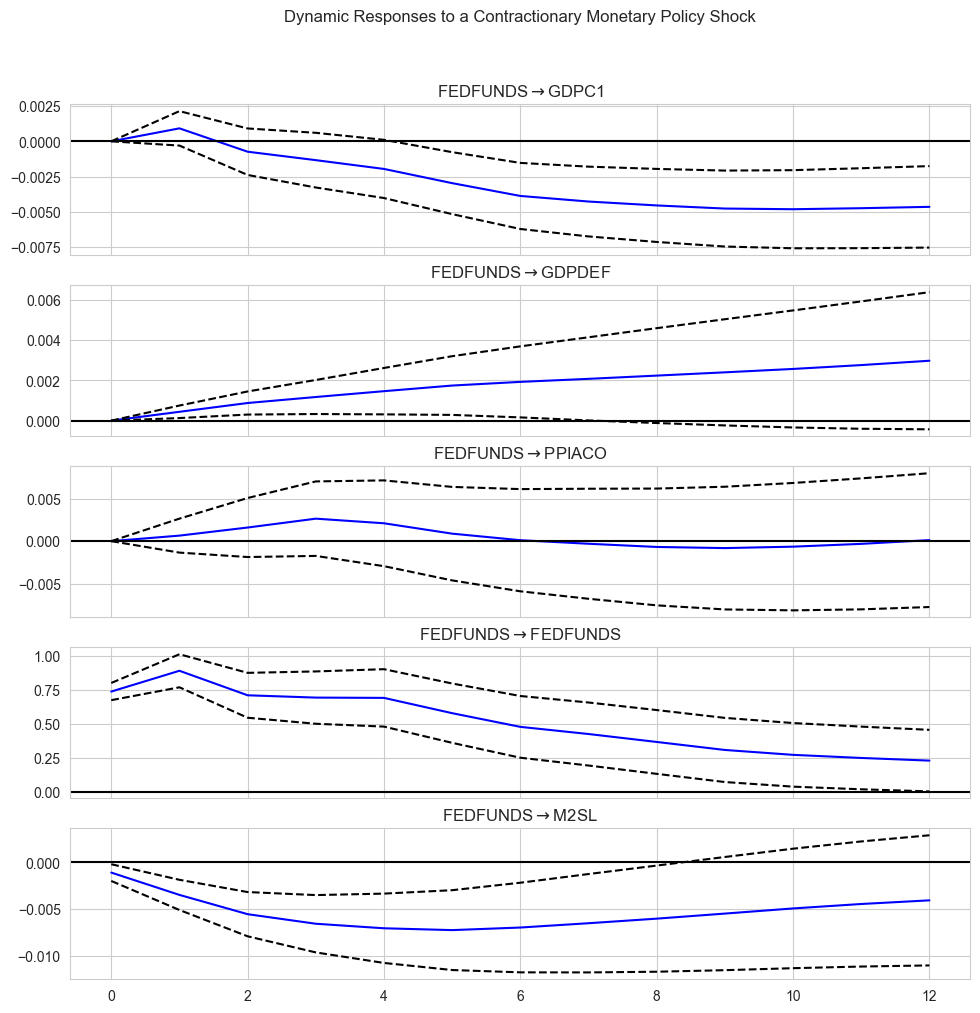

In [12]:
# Cholesky decomposition
cholesky_order = ["GDPC1", "GDPDEF", "PPIACO", "FEDFUNDS", "M2SL"]
df_ordered = df_q[cholesky_order]


p = selection.aic
model_identified = tsa.VAR(df_ordered)
results_identified = model_identified.fit(p)

# IRFs
periods = 12
irf = results_identified.irf(periods)

plt.figure(figsize=(10, 12))
irf.plot(orth=True, impulse="FEDFUNDS", signif=0.05)
plt.suptitle("Dynamic Responses to a Contractionary Monetary Policy Shock", y=1.02)
plt.show()

### (d)

The estimated responses make partial economic sense. The model correctly captures the Liquidity Effect, where the money supply (M2) drops immediately, and it exhibits a theoretically consistent delayed decline in Real GDP consistent with the idea that monetary policy affects the real economy with a lag. However, the response of the aggregate price level is counter-intuitive, as the GDP Deflator rises persistently following the contractionary shock rather than falling. This anomaly likely stems from the fact that the Federal Reserve often raises rates in anticipation of future inflation; because the model may not fully capture these forward-looking inflationary pressures despite the inclusion of commodity prices, it incorrectly interprets the subsequent inflation as a result of the rate hike rather than the condition that prompted it.

## Exercise 3

In [13]:
df_unrate = pd.read_csv(
    "../data/unrate.csv", parse_dates=["observation_date"], index_col="observation_date"
)
df_unrate = df_unrate.resample("QS").mean()
df_unrate.head()

,UNRATE
observation_date,
1948-01-01,3.733333
1948-04-01,3.666667
1948-07-01,3.766667
1948-10-01,3.833333
1949-01-01,4.666667


Lag = 2
Long Run Matrix
[[ 0.0902  0.    ]
 [-1.5277  7.4502]]


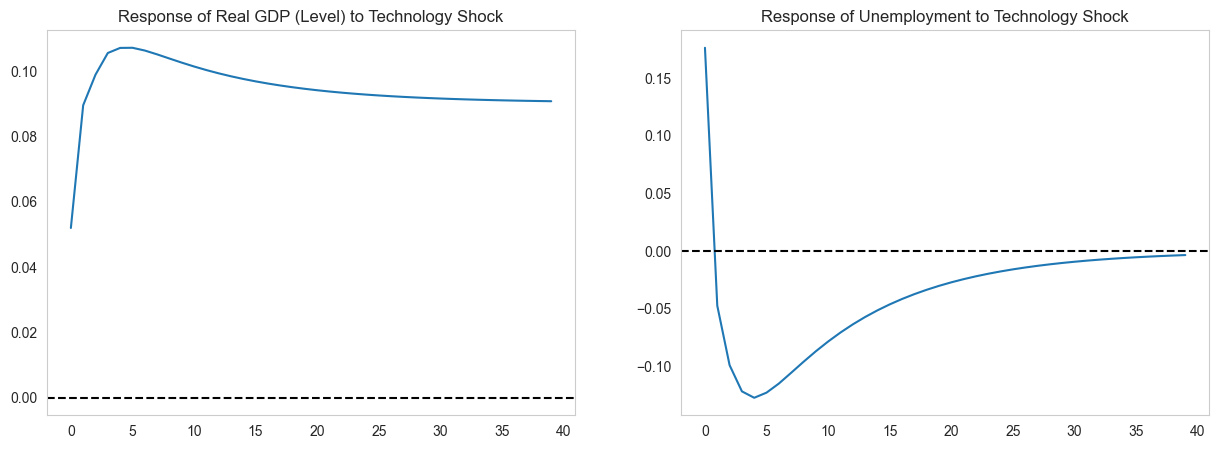

In [14]:
df_ex3 = pd.DataFrame()
df_ex3["GDP_Growth"] = np.log(df_q["GDPC1"]).diff() * 100
df_ex3["Unemployment"] = df_unrate["UNRATE"]
df_ex3 = df_ex3[["GDP_Growth", "Unemployment"]].dropna()

# VAR
model = tsa.VAR(df_ex3)
lag_selection = model.select_order(maxlags=12)
p = lag_selection.aic
print(f"Lag = {p}")
results = model.fit(p)

# BLANCHARD-QUAH
A_sum = np.sum(results.coefs, axis=0)
k = df_ex3.shape[1]
eye = np.eye(k)
Phi_1 = np.linalg.inv(eye - A_sum)
Sigma_u = results.sigma_u
M = Phi_1 @ Sigma_u @ Phi_1.T

# Cholesky Decomposition
D_lr = np.linalg.cholesky(M)
print("Long Run Matrix")
print(np.round(D_lr, 4))
B = (eye - A_sum) @ D_lr

# IRFs
periods = 40
irf_reduced = results.irf(periods)
struct_irfs = np.zeros((periods, k, k))

for i in range(periods):
    struct_irfs[i] = irf_reduced.irfs[i] @ B

tech_shock_gdp = struct_irfs[:, 0, 0]
tech_shock_unemp = struct_irfs[:, 1, 0]
tech_shock_gdp_level = np.cumsum(tech_shock_gdp)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(tech_shock_gdp_level)
axes[0].set_title("Response of Real GDP (Level) to Technology Shock")
axes[0].axhline(0, color="black", linestyle="--")
axes[0].grid()

axes[1].plot(tech_shock_unemp)
axes[1].set_title("Response of Unemployment to Technology Shock")
axes[1].axhline(0, color="black", linestyle="--")
axes[1].grid()

plt.show()

As we can see, the model was able to isolate the Technology shock (a demand shock would have returned to its initial level). The response of Unemployment also makes sense, as the line fluctuates and then returns to zero. Technology changes productivity, but doesn't permanently cause unemployment, the labor market should eventually adjust.

## Exercise 4

### (a)

TGARCH: Unlike the standard GARCH(1,1), which assumes a symmetric response to shocks (squaring the residual loses the sign), TGARCH explicitly modifies the variance equation to treat positive and negative shocks differently based on a threshold of zero.

### (b)

In [15]:
df_sp500 = pd.read_csv(
    "../data/sp500.csv", parse_dates=["observation_date"], index_col="observation_date"
)
df_sp500.head()

,SP500
observation_date,
2020-01-02,3257.85
2020-01-03,3234.85
2020-01-06,3246.28
2020-01-07,3237.18
2020-01-08,3253.05


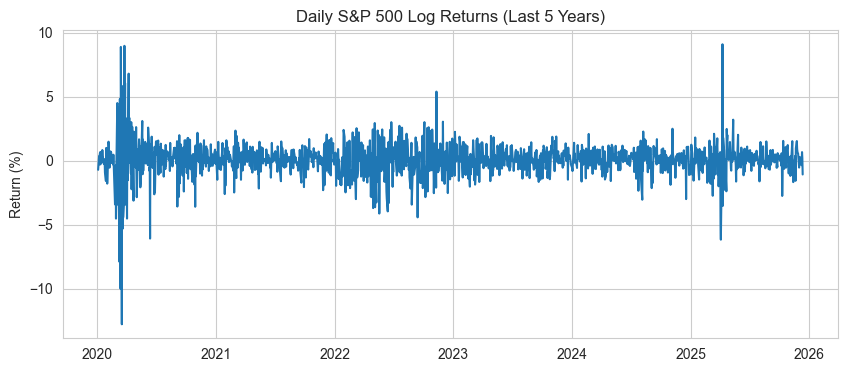

In [16]:
df_sp500 = df_sp500.dropna()

df_sp500["Return"] = np.log(df_sp500["SP500"] / df_sp500["SP500"].shift(1)) * 100
returns = df_sp500["Return"].dropna()

plt.figure(figsize=(10, 4))
plt.plot(returns)
plt.title("Daily S&P 500 Log Returns (Last 5 Years)")
plt.ylabel("Return (%)")
plt.show()

In [17]:
# GARCH(1,1)
garch_model = arch_model(returns, vol="Garch", p=1, q=1, mean="Constant", dist="Normal")
garch_result = garch_model.fit(disp="off")

# TGARCH(1,1)
tgarch_model = arch_model(
    returns, vol="Garch", p=1, o=1, q=1, mean="Constant", dist="Normal"
)
tgarch_result = tgarch_model.fit(disp="off")

print("Standard GARCH(1,1)")
print(garch_result.summary())

print("\nTGARCH(1,1)")
print(tgarch_result.summary())


print("\nModel Comparison")
print(f"GARCH(1,1)  | AIC: {garch_result.aic:.2f}, BIC: {garch_result.bic:.2f}")
print(f"TGARCH(1,1) | AIC: {tgarch_result.aic:.2f}, BIC: {tgarch_result.bic:.2f}")

--- Standard GARCH(1,1) Summary ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2162.69
Distribution:                  Normal   AIC:                           4333.39
Method:            Maximum Likelihood   BIC:                           4354.63
                                        No. Observations:                 1495
Date:                Tue, Dec 16 2025   Df Residuals:                     1494
Time:                        12:30:59   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0833  2.302

As we can see, the TGARCH model is preferred based on AIC.

## Exercise 5

### (a)

In [18]:
df_nasdaq = pd.read_csv(
    "../data/nasdaqcom.csv",
    parse_dates=["observation_date"],
    index_col="observation_date",
)
df_sp500 = pd.read_csv(
    "../data/sp500.csv", parse_dates=["observation_date"], index_col="observation_date"
)  # to ensure we can merge
df_nasdaq.head()

,NASDAQCOM
observation_date,
2020-01-02,9092.19
2020-01-03,9020.77
2020-01-06,9071.46
2020-01-07,9068.58
2020-01-08,9129.24


In [19]:
df = pd.concat([df_sp500, df_nasdaq], axis=1).dropna()
df.columns = ["SP500", "NASDAQ"]

df["ln_SP500"] = np.log(df["SP500"])
df["ln_NASDAQ"] = np.log(df["NASDAQ"])


def run_cointegration_test(y, x, sample_label):
    print(f"--- Test Results: {sample_label} ---")

    t_stat, p_value, crit_vals = ts.coint(y, x, autolag="AIC")

    print(f"t-statistic:   {t_stat:.4f}")
    print(f"p-value:       {p_value:.4f}")
    print(f"Critical Vals: {crit_vals}")

    if p_value < 0.05:
        print("Result: REJECT H0. The series are COINTEGRATED.\n")
    else:
        print("Result: FAIL TO REJECT H0. The series are NOT cointegrated.\n")


### (a)

In [20]:
run_cointegration_test(df["ln_SP500"], df["ln_NASDAQ"], "5(a) Full 5-Year Sample")

--- Test Results: 5(a) Full 5-Year Sample ---
t-statistic:   -1.9301
p-value:       0.5646
Critical Vals: [-3.90378069 -3.34022008 -3.04728814]
Result: FAIL TO REJECT H0. The series are NOT cointegrated.



### (b)

In [21]:
one_year_ago = df_sp500.index.max() - datetime.timedelta(days=365)
df_1y = df[df.index >= pd.to_datetime(one_year_ago)]

run_cointegration_test(df_1y["ln_SP500"], df_1y["ln_NASDAQ"], "5(b) Last 1-Year Sample")

--- Test Results: 5(b) Last 1-Year Sample ---
t-statistic:   -3.7143
p-value:       0.0176
Critical Vals: [-3.94078403 -3.36067957 -3.06145832]
Result: REJECT H0. The series are COINTEGRATED.



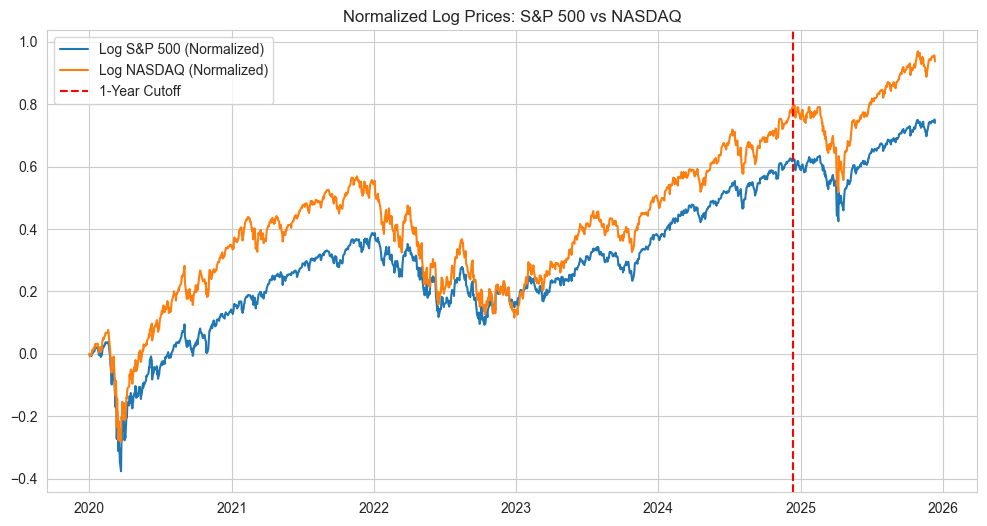

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(df["ln_SP500"] - df["ln_SP500"].iloc[0], label="Log S&P 500 (Normalized)")
plt.plot(df["ln_NASDAQ"] - df["ln_NASDAQ"].iloc[0], label="Log NASDAQ (Normalized)")
plt.axvline(
    pd.to_datetime(one_year_ago), color="red", linestyle="--", label="1-Year Cutoff"
)
plt.title("Normalized Log Prices: S&P 500 vs NASDAQ")
plt.legend()
plt.show()